In [4]:
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [5]:
#Pour l'architecture que j'ai entraîné sur Stim NB Lum Norm, j'ai pris le code suivant : 

def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        # Ajuste les dimensions
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Deuxième convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder(input_latent=256):
    input_img = tf.keras.Input(shape=(150, 150, 1))
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 256, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 256, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer_norm)
    x_recon = residual_block_recon(reshape_layer, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)

    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(150,150)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=x_recon)
    lr1 = 0.01
    lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=10000,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.summary()
    return model

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, dtype='float16')
dataset_white = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TRAIN',
    classes=['CAUCASIENS'],
    target_size=(150, 150),
    batch_size=16, 
    class_mode='input',
    shuffle=True,
    color_mode='grayscale')
dataset_east_asian = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TRAIN',
    classes=['ASIATIQUES'],
    target_size=(150, 150),
    batch_size=16,
    class_mode='input',
    shuffle=True,
    color_mode='grayscale')
dataset_mixed = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TRAIN',
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='input',
    shuffle=True,
    color_mode='grayscale')

Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.


Found 100 images belonging to 2 classes.


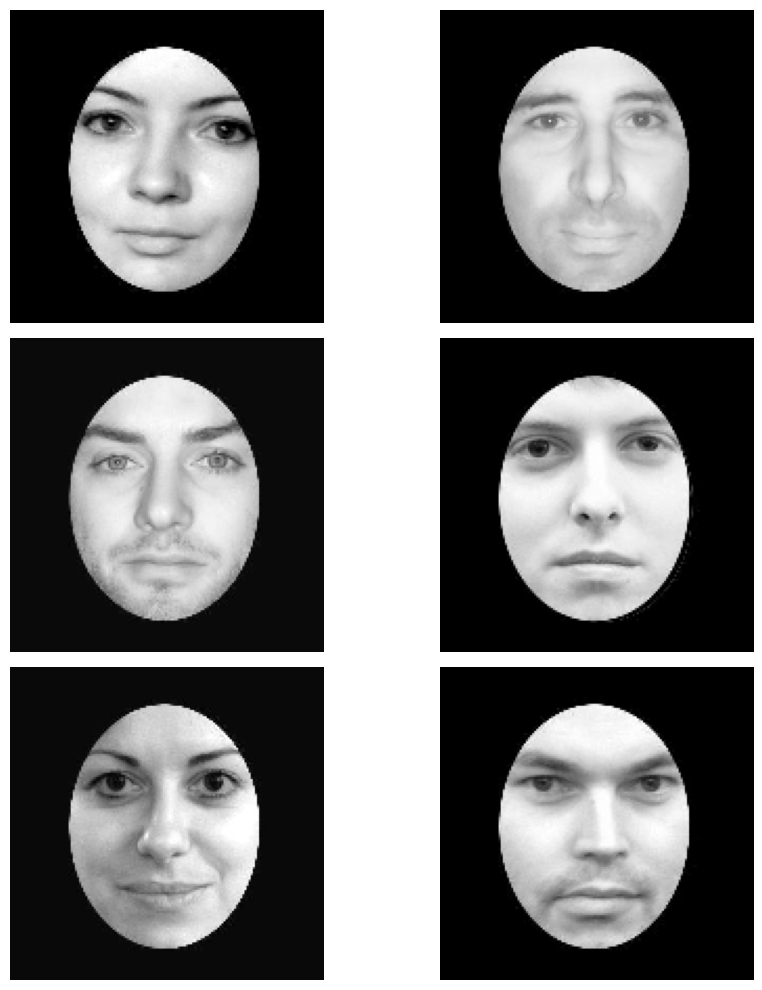

In [7]:
# Récupérer un lot d'images du générateur
batch = next(dataset_white)

# Extraire les images et les étiquettes du lot
images = batch[0]
labels = batch[1]

num_rows = 3
num_cols = 2

plt.figure(figsize=(10, 10))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[i].reshape((150,150)), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
shape = (150, 150,1)
input_latent = 128 #nombre de dimensions de l'espace latent, celui dont on veut qu'il modélise le face space de Tim Valentine donc
model = create_resnet_autoencoder()
chekpoint_path = 'stim_autoencoder.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=chekpoint_path,
    save_weights_only=False,
    save_frequency='epoch',
    save_best_only=True
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   288         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [9]:
history = model.fit(x=dataset_mixed, epochs=1, batch_size=16, validation_data=dataset_mixed)

4/4 [==============================] - 26s 3s/step - loss: 0.1671 - mae: 0.3787 - val_loss: 0.1785 - val_mae: 0.4031


In [14]:
get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('latent_space_layer_norm').output)

In [15]:
asian_predict = get_latent.predict(dataset_east_asian)
white_predict = get_latent.predict(dataset_white)

4/4 [==============================] - 0s 33ms/step


In [10]:
import numpy as np

def generator_to_array(generator):
    # Initialiser une liste pour stocker les échantillons
    num_samples = len(dataset_mixed)
    samples = []
    # Itérer sur le générateur pour obtenir les échantillons
    for i in range(num_samples):
        batch = generator.next()
        for image in batch[0]:
            samples.append(image)  # Ajouter uniquement les données (ignorer les étiquettes)
    return np.array(samples)

# Utilisation de la fonction avec votre datagen
white = generator_to_array(dataset_white)
asian = generator_to_array(dataset_east_asian)


hello


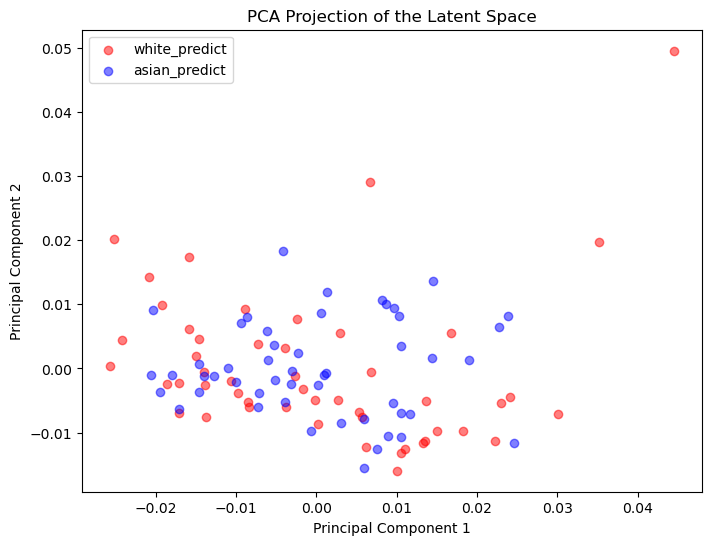

In [23]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler


pca = PCA(n_components=2)
latent_pca_white = pca.fit_transform(white_predict)
latent_pca_asian = pca.fit_transform(asian_predict)
print('hello')
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_pca_white[:, 0], latent_pca_white[:, 1], color='r', alpha=0.5, label='white_predict')
scatter_b = plt.scatter(latent_pca_asian[:, 0], latent_pca_asian[:, 1], color='b', alpha=0.5, label='asian_predict')
#plt.colorbar(scatter, ticks=range(10))
plt.legend(handles=[scatter, scatter_b])
plt.title('PCA Projection of the Latent Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
def cosinus_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
cosinus_similarity(dataset_east_asian, asian_predict)
cosinus_similarity(dataset_white, white_predict)
cosinus_similarity(asian_predict, white_predict)